In [23]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan


In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


## First, load the dataset from the weatherinszeged table from Thinkful's database.


In [3]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

## Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.


In [5]:
X=df[['humidity', 'windspeed', 'windbearing', 'pressure']]
y=df['temperature']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [9]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

In [11]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:31:35   Log-Likelihood:            -2.6241e+05
No. Observations:               77162   AIC:                         5.248e+05
Df Residuals:                   77157   BIC:                         5.249e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9541      0.258    147.058      

## Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.


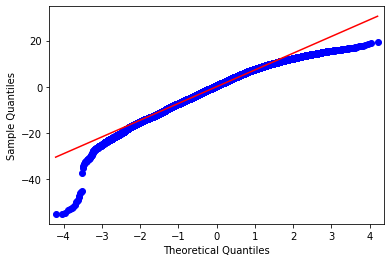

In [26]:
y_pred=model.predict(X_train_const)
sm.qqplot(model.resid, line="s")
plt.show()

It might be normal, hard to tell

In [14]:
print(model.resid.mean())

-9.583013847595141e-13


Mean of the residuals is 0

In [17]:
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p


1.6735150282305234e-82

Fails homoskedasticity assumption

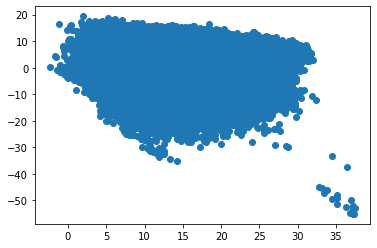

In [27]:
plt.scatter(y_pred, model.resid)

In [28]:
X_train_const.corr()

,const,humidity,windspeed,windbearing,pressure
const,NaN,NaN,NaN,NaN,NaN
humidity,NaN,1.000000,-0.223220,0.001999,0.004107
windspeed,NaN,-0.223220,1.000000,0.103184,-0.050214
windbearing,NaN,0.001999,0.103184,1.000000,-0.011495
pressure,NaN,0.004107,-0.050214,-0.011495,1.000000


No multicolinearity issues

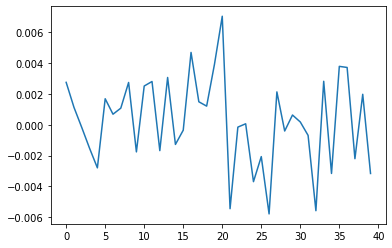

In [30]:
from statsmodels.tsa.stattools import acf

acf_data = acf(model.resid)

plt.plot(acf_data[1:])
plt.show()

Low autocorrelation

In [32]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
print(jarque_bera(model.resid))
print(normaltest(model.resid))


(3019.8931703649932, 0.0)
NormaltestResult(statistic=2685.7471984058016, pvalue=0.0)


Not a MG assumption but the residuals are not normally distributed

In [34]:
model.resid.shape

(77162,)

In [36]:
errordf=X_train_const.copy()
errordf['resid']=model.resid

In [40]:
errordf.corr()['resid']

const                   NaN
humidity      -5.199322e-15
windspeed     -3.605358e-15
windbearing   -8.969260e-15
pressure       9.809750e-15
resid          1.000000e+00
Name: resid, dtype: float64

Not correlated with the independent variables

## Load the houseprices data from Thinkful's database.
## Reimplement the model you built in the previous checkpoint.
## Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.


In [42]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()
drop_cols=[]
for col in df.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
df_clean=df.drop(columns=drop_cols).dropna()
df_clean['secondflrexists']=0
df_clean.loc[df['secondflrsf']>0,'secondflrexists']=1 #can prob drop 2nd fl sq ft
df_clean['totalsf']=df_clean['firstflrsf']=+df_clean['secondflrsf']
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']
y=df_clean['saleprice']
X=df_clean.drop(columns=['saleprice','id'])
X.mszoning.dtype==int
cat_cols=[c for c in X.columns if X[c].dtype=='O']
numeric_cols=[c for c in X.columns if X[c].dtype!='O']
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
df_clean['nicehood']=0
df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'nicehood']=1
X2 = df_clean[['overallqual','grlivarea', 'garagearea', 'totalbsmtsf','yearremodadd','yearbuilt','yrsbltqared','lotarea','nicehood']]
Y2 = df_clean.saleprice
X2 = sm.add_constant(X2)
results = sm.OLS(Y2, X2).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     440.4
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:12:47   Log-Likelihood:                -13104.
No. Observations:                1094   AIC:                         2.623e+04
Df Residuals:                    1084   BIC:                         2.628e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -2.15e+07   5.77e+06     -3.723   

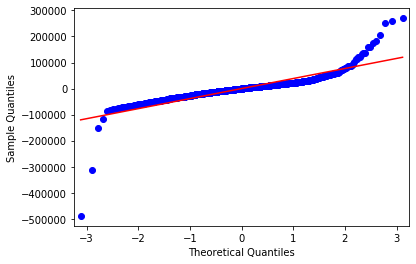

In [45]:
y2_pred=results.predict(X2)
sm.qqplot(results.resid, line="s")
plt.show()

In [51]:
print(jarque_bera(model.resid))
print(normaltest(model.resid))


(3019.8931703649932, 0.0)
NormaltestResult(statistic=2685.7471984058016, pvalue=0.0)


Not normal (not a real assumption)

In [48]:
_, p, _, _ = het_breuschpagan(results.resid, X2)
p


6.83072901707719e-70

Fails homoskedasicity test

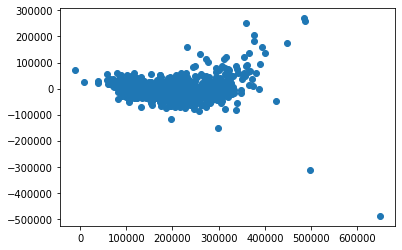

In [50]:
plt.scatter(y2_pred, results.resid)

In [52]:
X2.corr()

,const,overallqual,grlivarea,garagearea,totalbsmtsf,yearremodadd,yearbuilt,yrsbltqared,lotarea,nicehood
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overallqual,NaN,1.000000,0.610102,0.555315,0.547448,0.568582,0.590761,0.593817,0.169876,0.601720
grlivarea,NaN,0.610102,1.000000,0.488310,0.487685,0.287412,0.198778,0.201531,0.308590,0.340669
garagearea,NaN,0.555315,0.488310,1.000000,0.546099,0.413917,0.470809,0.473135,0.213104,0.494617
totalbsmtsf,NaN,0.547448,0.487685,0.546099,1.000000,0.302488,0.423763,0.424690,0.324476,0.387932
yearremodadd,NaN,0.568582,0.287412,0.413917,0.302488,1.000000,0.625905,0.628884,0.024308,0.427830
yearbuilt,NaN,0.590761,0.198778,0.470809,0.423763,0.625905,1.000000,0.999967,0.028954,0.502925
yrsbltqared,NaN,0.593817,0.201531,0.473135,0.424690,0.628884,0.999967,1.000000,0.028965,0.505313
lotarea,NaN,0.169876,0.308590,0.213104,0.324476,0.024308,0.028954,0.028965,1.000000,0.115667
nicehood,NaN,0.601720,0.340669,0.494617,0.387932,0.427830,0.502925,0.505313,0.115667,1.000000


Some multicolinearity

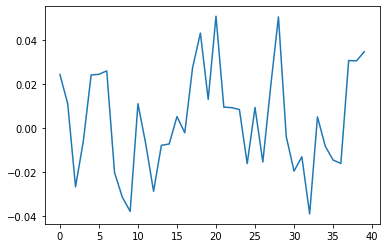

In [54]:
acf_data = acf(results.resid)

plt.plot(acf_data[1:])
plt.show()

No autocorrelation

In [55]:
errordf2=X2.copy()
errordf2['resid']=results.resid
errordf2.corr()['resid']

const                    NaN
overallqual     1.182749e-12
grlivarea      -7.177336e-14
garagearea      9.139773e-13
totalbsmtsf     7.995567e-13
yearremodadd    6.271843e-13
yearbuilt       2.160615e-12
yrsbltqared     2.157395e-12
lotarea        -6.021540e-15
nicehood        8.971889e-13
resid           1.000000e+00
Name: resid, dtype: float64

In [56]:
results.resid.mean()

-7.769079735588583e-06

No omitted variable bias

So, we see that we fail the homoskedicity assumption as well as there being a little multicolinearity. This means that the source of variance might be misattributed to the variables, and there will be difficulty testing whether the coefficients are significant